In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

# Cuckoo Search Algorithm

In [2]:
import torch
from torch import normal, randint, rand, multinomial
from math import pi, cos, sin, gamma
from tqdm import tqdm
from random import choices

<IPython.core.display.Javascript object>

In [3]:
from obj_f import ackley_f, weierstrass_f

<IPython.core.display.Javascript object>

In [104]:
# %load obj_f.py

import torch
from math import pi, cos, sin, gamma


def ackley_f(x):
    # x = x.cuda()
    if len(x.shape) == 1:
        x = x.unsqueeze(1)

    lhs = 20 * torch.exp((-0.2) * torch.sqrt((x ** 2).mean()))
    rhs = torch.cos(2 * pi * x).mean().exp()
    result = -1 * (lhs + rhs) + 20 + torch.exp(torch.Tensor([1]))  # .cuda()

    return result


def weierstrass_f(x, a=0.5, b=3, kmax=20):
    # x = x.cuda()
    x = (x * 0.5) / 100
    if len(x.shape) == 1:
        x = x.unsqueeze(1)

    D = x.shape[0]

    lhs = 0
    rhs = 0
    for k in range(kmax):
        lhs += torch.sum((a ** k) * torch.cos(2 * pi * (b ** k) * (x + 0.5)))
        rhs += (a ** k) * torch.cos(torch.Tensor([pi * (b ** k)]))
    result = lhs - D * rhs + 600
    return result

<IPython.core.display.Javascript object>

In [4]:
def argmin(lst):
    return min(range(len(lst)), key=lst.__getitem__)

<IPython.core.display.Javascript object>

In [79]:
class cuckoo_search(object):
    def __init__(
        self,
        function,
        pop_size=50,
        low_bound=-20,
        up_bound=20,
        dimension=10,
        alpha=0.1,
        pa=0.25,
        **kwargs
    ):

        self.pop_size = pop_size
        self.low_bound = low_bound
        self.up_bound = up_bound
        self.dimension = dimension
        self.obj_f = function
        self.alpha = alpha
        self.pa = pa

    def forward(self, iteration_time, **kwargs):

        init_points_list = self.random_generate_sampe(size=self.pop_size)
        points_list = init_points_list[:]

        function_values = [
            self.obj_f(sub_point, **kwargs) for sub_point in init_points_list
        ]

        global_best_value_each_step = []
        global_best_point_each_step = []
        global_best_index = argmin(function_values)
        global_best_value_each_step.append(function_values[global_best_index])
        global_best_point_each_step.append(points_list[global_best_index])

        for t in tqdm(range(iteration_time)):
            for i in range(self.pop_size):
                temp_point = points_list[i] + self.levy_fly()
                temp_point = self.adj_to_domain(temp_point)
                val = randint(high=self.pop_size, size=(1,))
                temp_value = self.obj_f(temp_point, **kwargs)
                if temp_value < function_values[val]:
                    points_list[val] = temp_point
                    function_values[val] = temp_value

            worse_nest_index = sorted(
                range(len(function_values)), key=lambda k: function_values[k]
            )[: int(self.pop_size * self.pa)]

            new_points_list = self.generate_new_point(points_list, worse_nest_index)
            for index, worse_index in enumerate(worse_nest_index):
                points_list[worse_index] = new_points_list[index]

            function_values = [
                self.obj_f(sub_point, **kwargs) for sub_point in points_list
            ]
            min_index = argmin(function_values)
            global_best_value_each_step.append(function_values[min_index])
            global_best_point_each_step.append(points_list[min_index])

        return (
            global_best_value_each_step,
            global_best_point_each_step,
        )

    def levy_fly(
        self,
    ):
        beta = 1.5
        sigma_u = (
            (gamma(1 + beta) * sin(0.5 * pi * beta))
            / (gamma(0.5 * (1 + beta)) * beta * (2 ** (0.5 * (beta - 1))))
        ) ** (1 / beta)
        sigma_v = 1
        step_part1 = normal(0, sigma_u, (self.dimension, 1))
        step_part2 = normal(0, sigma_v, (self.dimension, 1))
        step = step_part1 / (torch.abs(step_part2) ** (1 / beta))
        return self.alpha * step

    def generate_new_point(self, point_list, worse_points_index):
        number_of_new_points = len(worse_points_index)
        new_points = []
        for k in range(number_of_new_points):
            val = randint(high=self.pop_size, size=(2,))
            random_v = torch.nn.functional.relu(self.pa - rand(self.dimension, 1))
            new_points.append(
                point_list[worse_points_index[k]]
                + self.alpha
                * 0.005
                * random_v
                * (point_list[val[0]] - point_list[val[1]])
            )
        return new_points

    def adj_to_domain(self, x):
        low_index = x[:, 0] < self.low_bound
        x[low_index, 0] = self.low_bound
        up_index = x[:, 0] > self.up_bound
        x[up_index, 0] = self.up_bound
        return x

    def random_generate_sampe(self, size, *arg):
        init_points = (rand(self.dimension, size) - 0.5) * 40
        init_points = list(torch.split(init_points, split_size_or_sections=1, dim=1))
        return init_points

<IPython.core.display.Javascript object>

In [80]:
cso_ackley_10dim = cuckoo_search(function=ackley_f)
cso_ackley_20dim = cuckoo_search(function=ackley_f, dimension=20)

<IPython.core.display.Javascript object>

In [81]:
all_values_list_ackley_10dim = []
for i in range(20):
    values, points = cso_ackley_10dim.forward(350)
    all_values_list_ackley_10dim.append(torch.Tensor(values))

100%|██████████| 350/350 [00:17<00:00, 20.53it/s]


<IPython.core.display.Javascript object>

In [82]:
all_values_list_ackley_20dim = []
for i in range(20):
    values, points = cso_ackley_20dim.forward(500)
    all_values_list_ackley_20dim.append(torch.Tensor(values))

100%|██████████| 500/500 [00:24<00:00, 20.65it/s]


<IPython.core.display.Javascript object>

In [120]:
cso_weierstrass_10dim = cuckoo_search(function=weierstrass_f)
cso_weierstrass_20dim = cuckoo_search(function=weierstrass_f, dimension=20)

<IPython.core.display.Javascript object>

In [121]:
all_values_list_weierstrass_10dim = []
for i in range(20):
    values, points = cso_weierstrass_10dim.forward(150)
    all_values_list_weierstrass_10dim.append(torch.Tensor(values))

100%|██████████| 150/150 [00:41<00:00,  3.58it/s]


<IPython.core.display.Javascript object>

In [122]:
all_values_list_weierstrass_20dim = []
for i in range(20):
    values, points = cso_weierstrass_20dim.forward(1000)
    all_values_list_weierstrass_20dim.append(torch.Tensor(values))

100%|██████████| 1000/1000 [05:02<00:00,  3.31it/s]


<IPython.core.display.Javascript object>

# Visualization

In [59]:
import numpy as np
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

## Ackley function

In [113]:
all_values_tensor_ackley_10dim = torch.stack(all_values_list_ackley_10dim).numpy()
max_line_10d = all_values_tensor_ackley_10dim.max(axis=0)
mean_line_10d = all_values_tensor_ackley_10dim.mean(axis=0)
min_line_10d = all_values_tensor_ackley_10dim.min(axis=0)

all_values_tensor_ackley_20dim = torch.stack(all_values_list_ackley_20dim).numpy()
max_line_20d = all_values_tensor_ackley_20dim.max(axis=0)
mean_line_20d = all_values_tensor_ackley_20dim.mean(axis=0)
min_line_20d = all_values_tensor_ackley_20dim.min(axis=0)

<IPython.core.display.Javascript object>

In [94]:
[
    mean_line_10d[-1],
    all_values_tensor_ackley_10dim.std(axis=0)[-1],
    mean_line_20d[-1],
    all_values_tensor_ackley_20dim.std(axis=0)[-1],
]

[0.22822352, 0.040250536, 0.6673465, 0.06506984]

<IPython.core.display.Javascript object>

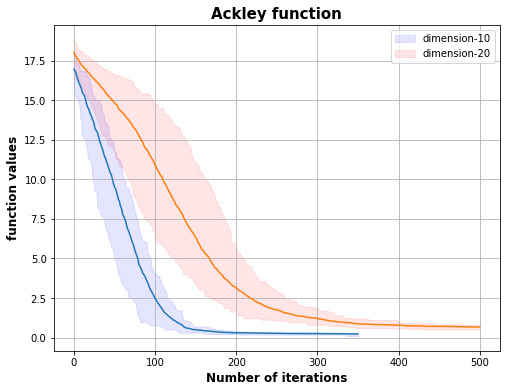

<IPython.core.display.Javascript object>

In [114]:
plt.figure(figsize=(8, 6))
plt.plot(range(351), mean_line_10d)
plt.fill_between(
    range(351), min_line_10d, max_line_10d, color="b", alpha=0.1, label="dimension-10"
)

plt.plot(range(501), mean_line_20d)
plt.fill_between(
    range(501), min_line_20d, max_line_20d, color="r", alpha=0.1, label="dimension-20"
)
plt.xlabel("Number of iterations", weight="bold", size=12)
plt.ylabel("function values", weight="bold", size=12)
plt.title("Ackley function", weight="bold", size=15)
plt.grid(True)
plt.legend()
plt.show()

## Weierstrass function

In [123]:
all_values_tensor_weierstrass_10dim = torch.stack(
    all_values_list_weierstrass_10dim
).numpy()
max_line_weierstrass_10d = all_values_tensor_weierstrass_10dim.max(axis=0)
mean_line_weierstrass_10d = all_values_tensor_weierstrass_10dim.mean(axis=0)
min_line_weierstrass_10d = all_values_tensor_weierstrass_10dim.min(axis=0)

all_values_tensor_weierstrass_20dim = torch.stack(
    all_values_list_weierstrass_20dim
).numpy()
max_line_weierstrass_20d = all_values_tensor_weierstrass_20dim.max(axis=0)
mean_line_weierstrass_20d = all_values_tensor_weierstrass_20dim.mean(axis=0)
min_line_weierstrass_20d = all_values_tensor_weierstrass_20dim.min(axis=0)

<IPython.core.display.Javascript object>

In [124]:
[
    max_line_weierstrass_10d[-1],
    all_values_tensor_weierstrass_10dim.std(axis=0)[-1],
    max_line_weierstrass_20d[-1],
    all_values_tensor_weierstrass_20dim.std(axis=0)[-1],
]

[601.9222, 0.49343252, 600.8185, 0.06331711]

<IPython.core.display.Javascript object>

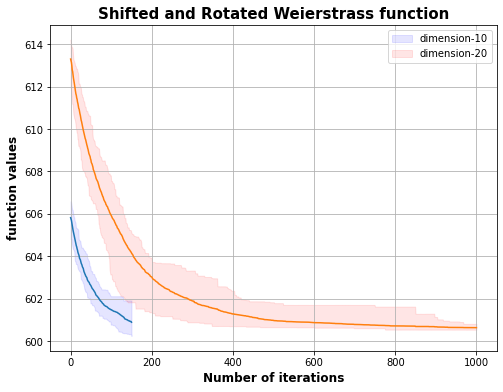

<IPython.core.display.Javascript object>

In [125]:
plt.figure(figsize=(8, 6))
plt.plot(range(151), mean_line_weierstrass_10d)
plt.fill_between(
    range(151),
    min_line_weierstrass_10d,
    max_line_weierstrass_10d,
    color="b",
    alpha=0.1,
    label="dimension-10",
)

plt.plot(range(1001), mean_line_weierstrass_20d)
plt.fill_between(
    range(1001),
    min_line_weierstrass_20d,
    max_line_weierstrass_20d,
    color="r",
    alpha=0.1,
    label="dimension-20",
)
plt.xlabel("Number of iterations", weight="bold", size=12)
plt.ylabel("function values", weight="bold", size=12)
plt.title("Shifted and Rotated Weierstrass function", weight="bold", size=15)
plt.grid(True)
plt.legend()
plt.show()